In [2]:
!pip install mplfinance
import pandas as pd
import mplfinance as mpf
import datetime
from datetime import date
import numpy as np
from sklearn import preprocessing

In [3]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

(Reading database ... 145506 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [6]:
import talib
from talib import  abstract

In [5]:
# data = pd.read_csv("S_P.csv",parse_dates=True)

data = pd.read_csv("S_P.csv",parse_dates=True)
start_date = (data['Date']== '2019-01-02' )

idx = np.where(start_date)[0][0]


data = pd.read_csv("S_P.csv",parse_dates=True, index_col='Date')


In [7]:
data.columns = map(str.lower, data.columns)
KD = abstract.STOCH(data)
data['K'] = KD['slowk']
data['D'] = KD['slowd']
data = data.fillna(0)

data_2019 = data.iloc[idx:,:]

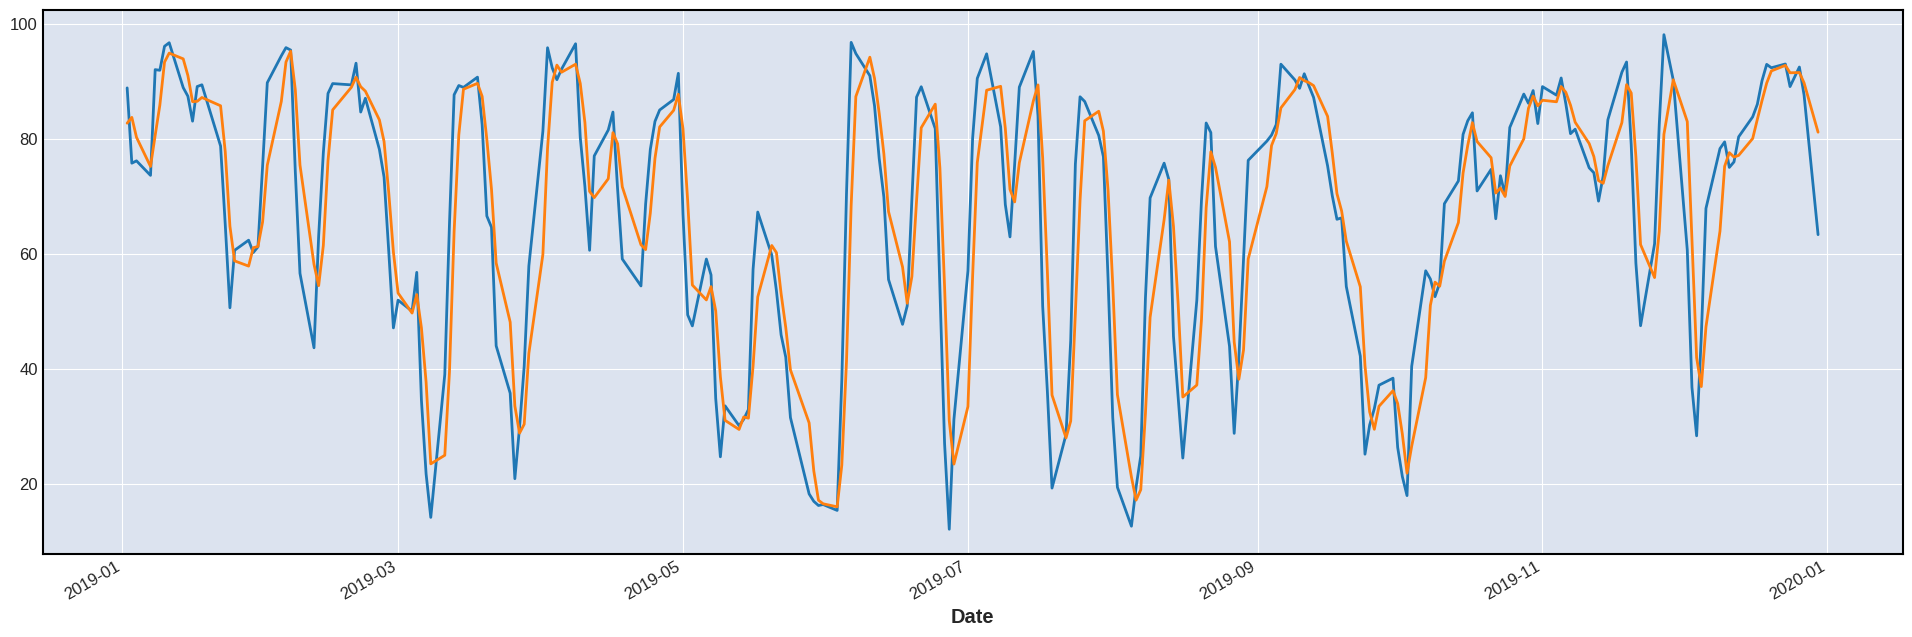

In [87]:

# mpf.plot(data_2019, type = 'candle',figratio=(10,2),figscale=0.5, mav=(10,30), volume=True, savefig='candle&ma&volume.png')

mpf.plot(data_2019, type = 'candle',figratio=(7,2),figscale=0.5, mav=(10,30), volume=True,savefig='candle&ma&volume.png')
data_2019['K'].plot(figsize=(24,8))
data_2019['D'].plot(figsize=(24,8))
plt.savefig("KDline.png")


In [9]:
sma_5 = abstract.SMA(data,10)  ## 5就是timeperiod
sma_30 = abstract.SMA(data,30)
data['sma_5'] = sma_5
data['sma_30'] = sma_30
data = data.fillna(0)



data_normalize = (data-data.min())/(data.max()-data.min())
data_normalize.pop('adj close')

data_2018 = (data_normalize.index.year == 2018)
idx = np.where(data_2018)[0][0]
trainData = data_normalize.iloc[:idx,:]
testData = data_normalize.iloc[idx:, :]

y_trainData = trainData.pop('close')
y_testData = testData.pop('close')



In [10]:
x_train = []   #預測點的前 30 天的資料
y_train = []   #預測點
x_test = []
y_test = []

for i in range(30, trainData.shape[0]):  # trainData.shape[0] 是訓練集總數
    x_train.append(trainData.iloc[i-30:i, :])
    y_train.append(y_trainData.iloc[i])
for i in range(30, testData.shape[0]):
    x_test.append(testData.iloc[i-30:i, :])
    y_test.append(y_testData.iloc[i]
                  )
x_train, y_train = np.array(x_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
x_test, y_test = np.array(x_test), np.array(y_test)


In [11]:
import tensorflow as tf
import keras
from keras.layers import LSTM
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, SimpleRNN, GRU
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dropout

In [47]:
def create_RNN(x_train, y_train, x_test, y_test):
  batch_size = None
  steps = 30
  input_dim = 8
  epochs = 20
  model = Sequential()
  # 加 RNN 隱藏層(hidden layer)
  model.add(SimpleRNN(
      # 如果後端使用tensorflow，batch_input_shape 的 batch_size 需設為 None.
      # 否則執行 model.evaluate() 會有錯誤產生.
      batch_input_shape=(batch_size, steps, input_dim), 
      units= 50,
      unroll=True,
  ))
  model.add(Dropout(0.2))
  model.add(Dense(10,activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs,
            verbose=1, validation_data=(x_test, y_test))
  return hist, model

def create_LSTM(x_train, y_train, x_test, y_test):
  batch_size = None
  steps = 30
  input_dim = 8
  epochs = 20
  lstm = Sequential()
  # 加 RNN 隱藏層(hidden layer)
  lstm.add(LSTM(
      # 如果後端使用tensorflow，batch_input_shape 的 batch_size 需設為 None.
      # 否則執行 model.evaluate() 會有錯誤產生.
      batch_input_shape=(batch_size, steps, input_dim), 
      units= 50,
      unroll=True,
  )) 
  lstm.add(Dense(10,activation='relu'))
  lstm.add(Dense(1))
  lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  hist = lstm.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs,
            verbose=1, validation_data=(x_test, y_test))
  return hist, lstm

def create_GRU(x_train, y_train, x_test, y_test):
  batch_size = None
  steps = 30
  input_dim = 8
  epochs = 20
  model = Sequential()
  # 加 RNN 隱藏層(hidden layer)
  model.add(GRU(
      # 如果後端使用tensorflow，batch_input_shape 的 batch_size 需設為 None.
      # 否則執行 model.evaluate() 會有錯誤產生.
      batch_input_shape=(batch_size, steps, input_dim), 
      units= 50,
      unroll=True,
  )) 
  model.add(Dense(10,activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs,
            verbose=1, validation_data=(x_test, y_test))
  return hist, model



In [13]:
LSTM_hist, LSTM = create_LSTM(x_train,y_train,x_test,y_test)


Epoch 1/20
188/188 [==============================] - 7s 18ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 2/20
188/188 [==============================] - 2s 10ms/step - loss: 1.0408e-04 - mean_squared_error: 1.0408e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/20
188/188 [==============================] - 2s 12ms/step - loss: 6.9412e-05 - mean_squared_error: 6.9412e-05 - val_loss: 7.3103e-04 - val_mean_squared_error: 7.3103e-04
Epoch 4/20
188/188 [==============================] - 2s 10ms/step - loss: 6.2941e-05 - mean_squared_error: 6.2941e-05 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 5/20
188/188 [==============================] - 2s 12ms/step - loss: 5.5715e-05 - mean_squared_error: 5.5715e-05 - val_loss: 4.4615e-04 - val_mean_squared_error: 4.4615e-04
Epoch 6/20
188/188 [==============================] - 2s 11ms/step - loss: 5.5218e-05 - mean_squared_error: 5.5218e-05 - val_loss: 2.3749

In [48]:
RNN_hist, RNN = create_RNN(x_train,y_train,x_test,y_test)

Epoch 1/20
188/188 [==============================] - 3s 7ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 9.8073e-04 - mean_squared_error: 9.8073e-04 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 8.7306e-04 - mean_squared_error: 8.7306e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 7/20
1

In [18]:
GRU_hist, GRU = create_GRU(x_train,y_train,x_test,y_test) 

Epoch 1/20
188/188 [==============================] - 8s 17ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 6.6652e-04 - val_mean_squared_error: 6.6652e-04
Epoch 2/20
188/188 [==============================] - 2s 13ms/step - loss: 7.2727e-05 - mean_squared_error: 7.2727e-05 - val_loss: 5.1099e-04 - val_mean_squared_error: 5.1099e-04
Epoch 3/20
188/188 [==============================] - 2s 13ms/step - loss: 4.9699e-05 - mean_squared_error: 4.9699e-05 - val_loss: 4.4948e-04 - val_mean_squared_error: 4.4948e-04
Epoch 4/20
188/188 [==============================] - 3s 14ms/step - loss: 4.5527e-05 - mean_squared_error: 4.5527e-05 - val_loss: 6.5589e-04 - val_mean_squared_error: 6.5589e-04
Epoch 5/20
188/188 [==============================] - 3s 14ms/step - loss: 4.5194e-05 - mean_squared_error: 4.5194e-05 - val_loss: 2.5169e-04 - val_mean_squared_error: 2.5169e-04
Epoch 6/20
188/188 [==============================] - 2s 13ms/step - loss: 4.7688e-05 - mean_squared_error: 4.768

In [78]:
import matplotlib.pyplot as plt

def plot_loss(hist, modelname):
  name = modelname+" loss"
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.title(modelname+" loss")
  plt.savefig(name)
  plt.show()

def denormalized(data, data_normalize):
  denormal = data_normalize*(data['close'].max()-data['close'].min())+data['close'].min()
  return denormal
def plot_predict_close(x_test, y_test, model, modelname):
  predict_y = model.predict(x_test)
  denormal_predict_y = denormalized(data, predict_y)
  denormal_y = denormalized(data, y_test)
  name = modelname+' prediction'
  plt.plot(denormal_y)
  plt.plot(denormal_predict_y)
  plt.legend(['True', 'Predict'], loc='upper right')
  plt.title(name)
  plt.savefig(name)
  plt.show()


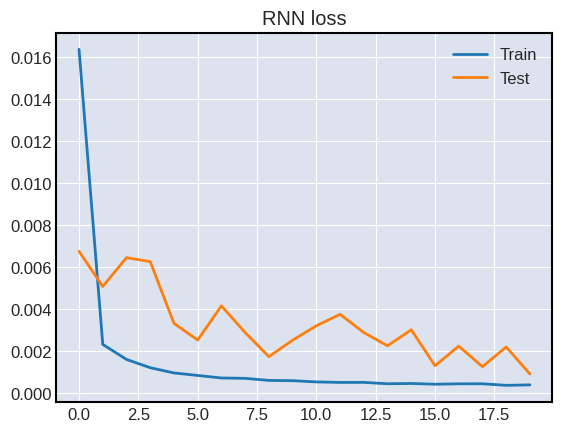

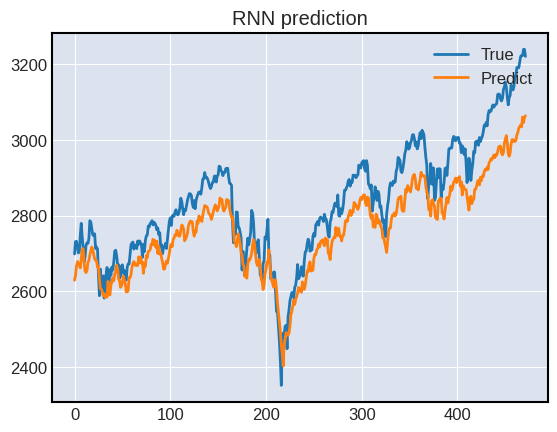

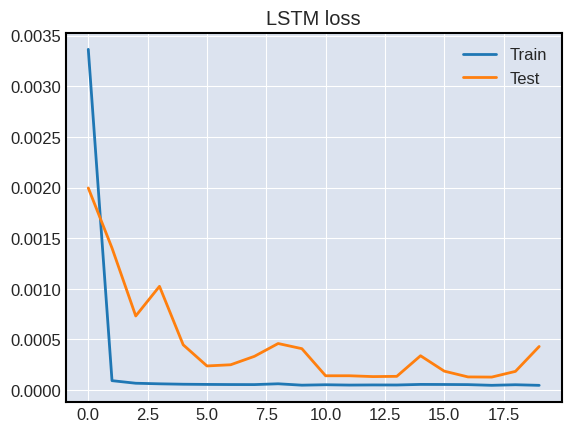

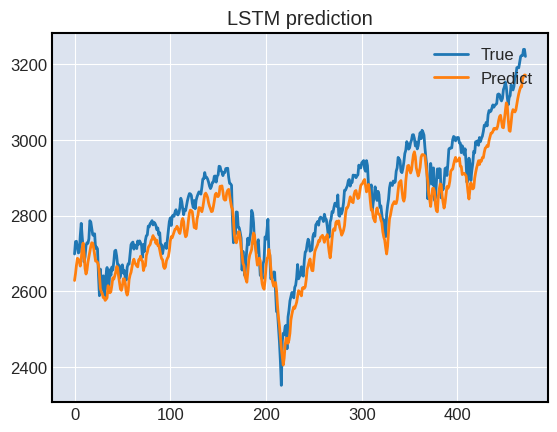

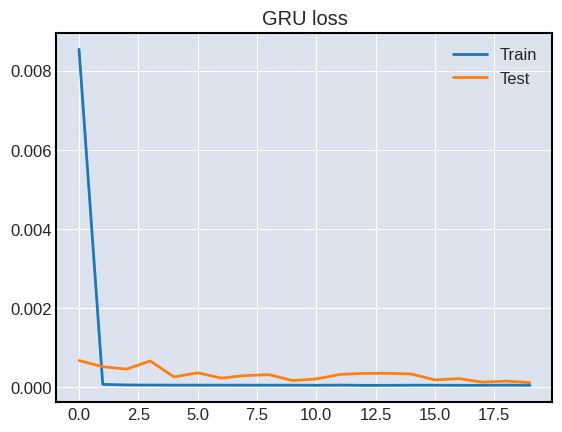

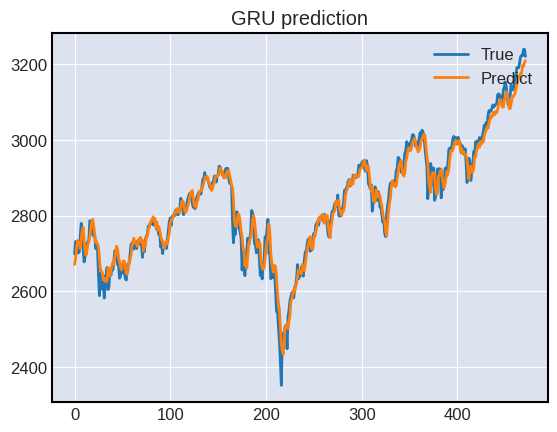

In [79]:
plot_loss(RNN_hist, 'RNN')
plot_predict_close(x_test, y_test, RNN, "RNN")
plot_loss(LSTM_hist, 'LSTM')
plot_predict_close(x_test, y_test, LSTM, "LSTM")
plot_loss(GRU_hist, 'GRU')
plot_predict_close(x_test, y_test, GRU, "GRU")

In [71]:

data_2020 = pd.read_csv("2020.csv",parse_dates=True, index_col='Date')
data_2020.columns = map(str.lower, data_2020.columns)
KD = abstract.STOCH(data_2020)
data_2020['K'] = KD['slowk']
data_2020['D'] = KD['slowd']

sma_5 = abstract.SMA(data_2020,10)  ## 5就是timeperiod
sma_30 = abstract.SMA(data_2020,30)
data_2020['sma_5'] = sma_5
data_2020['sma_30'] = sma_30

data_2020 = (data_2020-data.min()) / (data.max()-data.min())
data_2020.pop('adj close')
y_testData_2020 = data_2020.pop('close')
data_2020 = data_2020.fillna(0)

In [72]:
x_test_2020 = []
y_test_2020 = []

for i in range(30, data_2020.shape[0]):
    x_test_2020.append(data_2020.iloc[i-30:i, :])
    y_test_2020.append(y_testData_2020.iloc[i]
                  )

x_test_2020, y_test_2020 = np.array(x_test_2020), np.array(y_test_2020)


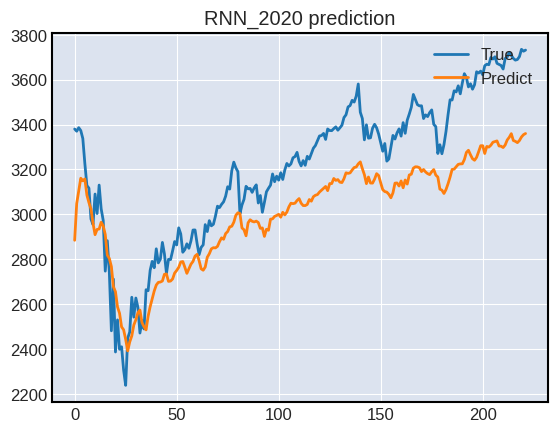

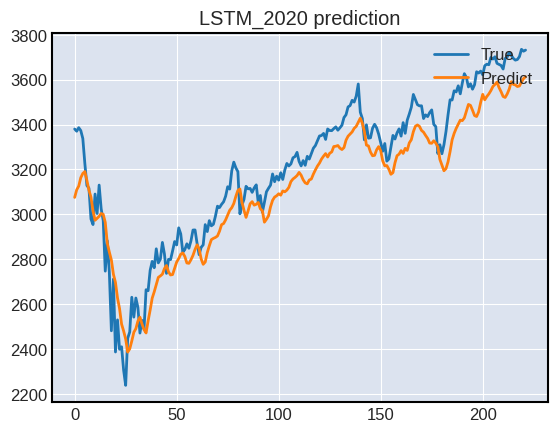

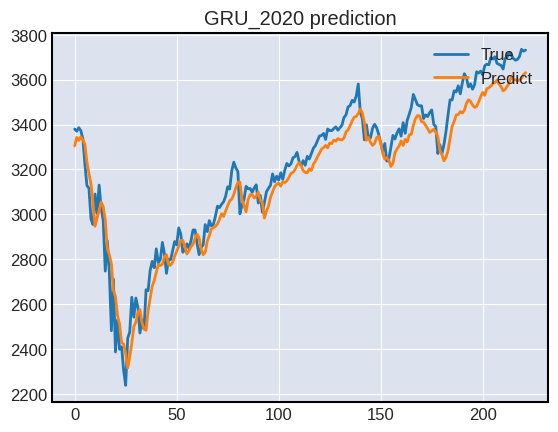

In [80]:
plot_predict_close(x_test_2020, y_test_2020, RNN, "RNN_2020")
plot_predict_close(x_test_2020, y_test_2020, LSTM, "LSTM_2020")
plot_predict_close(x_test_2020, y_test_2020, GRU, "GRU_2020")

In [91]:
data_normalize

,open,high,low,close,volume,K,D,sma_5,sma_30
Date,,,,,,,,,
1994-01-03,0.009747,0.007927,0.010184,0.009468,0.022301,0.000000,0.000000,0.000000,0.000000
1994-01-04,0.009366,0.007909,0.010213,0.009985,0.027236,0.000000,0.000000,0.000000,0.000000
1994-01-05,0.009882,0.008241,0.010741,0.010221,0.033654,0.000000,0.000000,0.000000,0.000000
1994-01-06,0.010117,0.008661,0.011134,0.010067,0.030676,0.000000,0.000000,0.000000,0.000000
1994-01-07,0.009953,0.009111,0.011138,0.011060,0.027089,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2019-12-23,0.992458,0.992812,0.995687,0.994284,0.266197,0.930219,0.932323,0.990262,0.994141
2019-12-24,0.992244,0.992330,0.995047,0.994059,0.112011,0.890923,0.919382,0.993088,0.995580
2019-12-26,0.992867,0.997200,0.997438,0.999961,0.187540,0.924888,0.919800,0.996145,0.997143
